In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rohit-nlp-3/CLAN_data.csv
/kaggle/input/rohit-nlp-3/CLAN_data.xlsx


In [2]:
!pip install bert-score evaluate nltk rouge_score

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c3501ed3df961a21109f2028dcf64ec50868c27c3782acba892fd22f8aa001ca
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [3]:
DATASET_DIR='/kaggle/input/rohit-nlp-3/'

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv(DATASET_DIR+"CLAN_data.csv")  # ensure this file is uploaded

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 1967, Val size: 422, Test size: 422


In [5]:
import re

CONTRACTIONS={
    "ain't": "am not",
    "can't": "cannot",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he's": "he is",
    "here's": "here is",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it's": "it is",
    "let's": "let us",
    "she's": "she is",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we're": "we are",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who's": "who is",
    "won't": "will not",
    "wouldn't": "would not",
    "you'd": "you would",
    "you're": "you are",
    "you've": "you have",
    "AI": "Artificial Intelligence",
    "CIA": "Central Intelligence Agency",
    "CNN": "Cable News Network",
    "EU": "European Union",
    "FBI": "Federal Bureau of Investigation",
    "GDP": "Gross Domestic Product",
    "ML": "Machine Learning",
    "NATO": "North Atlantic Treaty Organization",
    "NYC": "New York City",
    "U.K.": "United Kingdom",
    "U.S.": "United States",
    "UFO": "Unidentified Flying Object",
    "UK": "United Kingdom",
    "UN": "United Nations",
    "USA": "United States of America",
    "WHO": "World Health Organization",
    "B.J.P": "Bharatiya Janata Party",
    "F.A.S.T": "Fellowship in Advanced Science and Technology",
    "N.I.H": "National Institutes of Health"
}


def preprocess_text(text):
    text = text.lower()
    
    for k, v in CONTRACTIONS.items():
        text = re.sub(rf"\b{k.lower()}\b", v.lower(), text)
    
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove links
    text = re.sub(r"[^a-zA-Z0-9\s]", '', text)  # remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # remove extra whitespace
    
    return "normalize: "+text

# Apply preprocessing
train_df['Social Media Post'] = train_df['Social Media Post'].apply(preprocess_text)
val_df['Social Media Post'] = val_df['Social Media Post'].apply(preprocess_text)
test_df['Social Media Post'] = test_df['Social Media Post'].apply(preprocess_text)


In [6]:
from datasets import Dataset
# HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['Social Media Post', 'Normalized Claim']])
val_dataset = Dataset.from_pandas(val_df[['Social Media Post', 'Normalized Claim']])
test_dataset= Dataset.from_pandas(test_df[['Social Media Post', 'Normalized Claim']])
print(val_dataset[2])

{'Social Media Post': 'normalize: a report has revealed hmrc employ just 522 staff to tackle tens of billions of tax evasion by the superrich but the dwp employ 4045 to tackle benefit fraud if you ever needed confirmation of this lousy governments priorities this is it', 'Normalized Claim': 'HMRC employs just 522 staff to tackle tens of billions of tax evasion by the super-rich.', '__index_level_0__': 1102}


In [7]:
from transformers import AutoTokenizer, BartForConditionalGeneration,T5ForConditionalGeneration,Seq2SeqTrainer, Seq2SeqTrainingArguments

model_name = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [8]:
# Tokenize
def tokenize_fn(examples):
    inputs = tokenizer(examples['Social Media Post'], padding="max_length", truncation=True, max_length=128)
    targets = tokenizer(examples['Normalized Claim'], padding="max_length", truncation=True, max_length=128)
    inputs['labels'] = targets['input_ids']
    return inputs

train_dataset = train_dataset.map(tokenize_fn, batched=True)
val_dataset = val_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/1967 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

Map:   0%|          | 0/422 [00:00<?, ? examples/s]

In [9]:
#only 100 smallest samples for testing
# train_dataset = train_dataset.select(range(100))
# val_dataset = val_dataset.select(range(5))

In [10]:
from bert_score import score as bert_score
from evaluate import load
# Load metrics
rouge = load("rouge")
bleu = load("bleu")

In [11]:
import torch
def compute_metrics(eval_pred):
    preds= np.where(eval_pred.predictions != -100, eval_pred.predictions, tokenizer.pad_token_id)
    refs= np.where(eval_pred.label_ids != -100, eval_pred.label_ids, tokenizer.pad_token_id)
    preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    refs = tokenizer.batch_decode(refs, skip_special_tokens=True)
    # refs = list(val_dataset['Normalized Claim'])

    rouge_output = rouge.compute(predictions=preds, references=refs)
    bleu_output = bleu.compute(predictions=preds,references=[[r] for r in refs])
    P, R, F1 = bert_score(preds, refs, lang="en", verbose=True,device="cuda")
    
    return {
        "rougeL": rouge_output['rougeL'],
        "bleu4": bleu_output["bleu"],
        "bertscore_f1": F1.mean().item()
    }





# Training args
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=1e-4,
    predict_with_generate=True,
    save_total_limit=1,
    report_to='none',
    load_best_model_at_end=True,
)

# Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-7bff3d0fb5e4>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Rougel,Bleu4,Bertscore F1
1,5.481200,1.314935,0.267628,0.091138,0.864172
2,0.828600,0.491737,0.285673,0.097828,0.870238
3,0.469500,0.460704,0.288316,0.106817,0.872766
4,0.375000,0.452389,0.303278,0.123668,0.875195
5,0.317300,0.452758,0.313837,0.126116,0.875613
6,0.276500,0.454837,0.315270,0.129095,0.877754
7,0.248600,0.455367,0.324108,0.138719,0.879764
8,0.226600,0.461568,0.322485,0.133009,0.879363
9,0.212000,0.462568,0.326831,0.133588,0.878824
10,0.203500,0.462879,0.330063,0.140028,0.879797


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.39 seconds, 124.46 sentences/sec


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.12 seconds, 135.11 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.19 seconds, 132.13 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.25 seconds, 130.01 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.20 seconds, 131.69 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.13 seconds, 134.86 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.06 seconds, 137.77 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.12 seconds, 135.36 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.04 seconds, 138.93 sentences/sec


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.11 seconds, 135.90 sentences/sec


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=310, training_loss=0.8638914369767712, metrics={'train_runtime': 592.4965, 'train_samples_per_second': 33.199, 'train_steps_per_second': 0.523, 'total_flos': 1499189516697600.0, 'train_loss': 0.8638914369767712, 'epoch': 10.0})

In [12]:
logs = trainer.state.log_history
logs

[{'loss': 5.4812,
  'grad_norm': 33.58464813232422,
  'learning_rate': 9e-05,
  'epoch': 1.0,
  'step': 31},
 {'eval_loss': 1.3149348497390747,
  'eval_rougeL': 0.2676282382127788,
  'eval_bleu4': 0.09113778112695443,
  'eval_bertscore_f1': 0.86417156457901,
  'eval_runtime': 28.0791,
  'eval_samples_per_second': 15.029,
  'eval_steps_per_second': 0.249,
  'epoch': 1.0,
  'step': 31},
 {'loss': 0.8286,
  'grad_norm': 0.8932819366455078,
  'learning_rate': 8e-05,
  'epoch': 2.0,
  'step': 62},
 {'eval_loss': 0.49173739552497864,
  'eval_rougeL': 0.2856733345069471,
  'eval_bleu4': 0.09782821421200706,
  'eval_bertscore_f1': 0.870238184928894,
  'eval_runtime': 20.3066,
  'eval_samples_per_second': 20.781,
  'eval_steps_per_second': 0.345,
  'epoch': 2.0,
  'step': 62},
 {'loss': 0.4695,
  'grad_norm': 0.7415908575057983,
  'learning_rate': 7e-05,
  'epoch': 3.0,
  'step': 93},
 {'eval_loss': 0.4607040584087372,
  'eval_rougeL': 0.2883160446686011,
  'eval_bleu4': 0.10681689175271378,
  

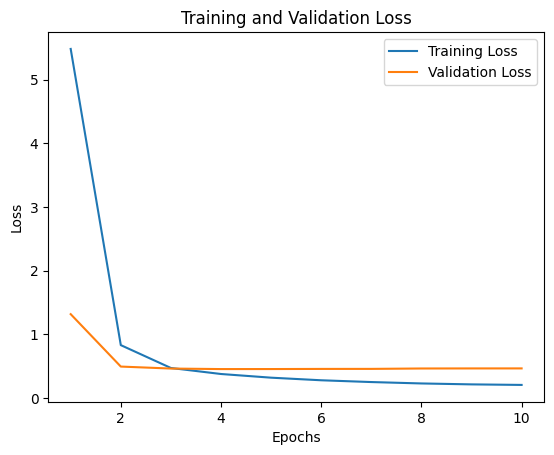

In [13]:
import matplotlib.pyplot as plt

#plot training and validation loss
train_loss = [log['loss'] for log in logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [14]:
trainer.predict(test_dataset).metrics

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/13 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/7 [00:00<?, ?it/s]

done in 3.20 seconds, 131.88 sentences/sec


{'test_loss': 0.46833372116088867,
 'test_rougeL': 0.3085705646592538,
 'test_bleu4': 0.11575944818265867,
 'test_bertscore_f1': 0.874789297580719,
 'test_runtime': 20.0522,
 'test_samples_per_second': 21.045,
 'test_steps_per_second': 0.349}